In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import files

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 1.jpeg to 1.jpeg
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.jpeg to 5.jpeg
Saving 6.png to 6.png
Saving 7.png to 7.png
Saving 8.png to 8.png
Saving 9.png to 9.png
Saving 10.png to 10.png
Saving 11.jpeg to 11.jpeg
Saving 12.png to 12.png
Saving 13.png to 13.png
Saving 14.jpeg to 14.jpeg
Saving 15.png to 15.png
Saving 16.jpeg to 16.jpeg
User uploaded file "1.jpeg" with length 3935 bytes
User uploaded file "2.png" with length 2954 bytes
User uploaded file "3.png" with length 3225 bytes
User uploaded file "4.png" with length 2943 bytes
User uploaded file "5.jpeg" with length 6630 bytes
User uploaded file "6.png" with length 3594 bytes
User uploaded file "7.png" with length 2849 bytes
User uploaded file "8.png" with length 2789 bytes
User uploaded file "9.png" with length 3910 bytes
User uploaded file "10.png" with length 2261 bytes
User uploaded file "11.jpeg" with length 3482 bytes
User uploaded file "12.png" with length 3186 bytes
User uploaded file

Datasets_train_shape:(12, 784)  Datasets_test_shape:(4, 784)


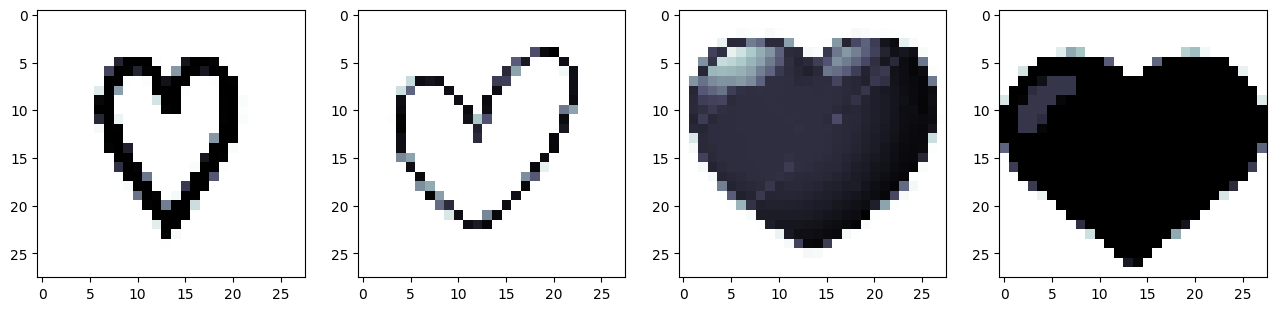

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input

# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './heart/'

# 이미지 읽기
def img_read(src, file, target_size=(28, 28)):
    img = cv2.imread(os.path.join(src, file), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, target_size)  # Resize images to a fixed size
        return img / 255.0
    return None

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(src)

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.

X, Y = [], []
for file in files:
    img = img_read(src, file)
    if img is not None:
        X.append(img.flatten())  # 이미지를 벡터로 변환
        Y.append(float(file[:-4]))

# Train set, Test set으로 나누기
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

# numpy array로 변환
x_train = np.array(x_train)
x_test = np.array(x_test)

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train), np.shape(x_test)))

import matplotlib.pyplot as plt

# images 확인용
fig = plt.figure(figsize=(20, 10))
nplot = 5
for i in range(1, nplot):
    ax = fig.add_subplot(1, nplot, i)
    ax.imshow(x_train[i, :].reshape(28, 28).astype(float), cmap=plt.cm.bone)  # Reshape the flattened image back to 28x28
plt.show()

In [ ]:
# network parameters
input_shape = np.shape(x_train[0])[0]
original_dim= input_shape
intermediate_dim = 512
latent_dim = 2

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_shape (InputLayer)       [(None, 784)]        0           []                               
                                                                                                  
 encoder_hidden1 (Dense)        (None, 512)          401920      ['input_shape[0][0]']            
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                            

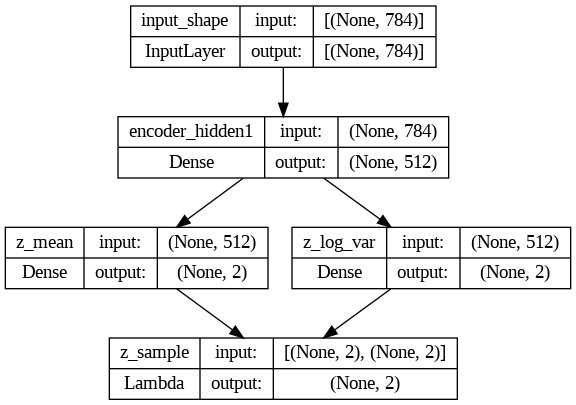

In [ ]:
def encoder():
  # 인코더의 입력층을 생성합니다.
  inputs = Input(shape=(input_shape,), name='input_shape')

  # 인코더의 hidden층을 생성합니다. 500개의 유닛을 사용했습니다.
  encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)

  # 평균(mean)과 표준편차(sigma)층을 정의합니다.
  # 이때 sigma 대신 log variance를 사용합니다. 이는 신경망의 출력은 음수를 가질 수 있지만 sigma는 항상 양수여야 하기 때문입니다.
  # 각각 2개의 유닛을 사용했습니다.
  z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
  z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_hidden)

  # 평균과 표준편차를 래핑하여 Z_sampling층을 만듭니다.

  # Z 샘플링 함수 생성
  def sampling(args):
      z_mean, z_log_var = args
      batch = shape(z_mean)[0]
      dim = shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출
      epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (latent_dim,), name='z_sample')([z_mean, z_log_var])

  # 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.
  return Model(inputs,[z_mean,z_log_var,z_sampling], name='encoder')

encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [ ]:
def decoder():

  # 디코더의 입력층을 생성합니다. (Decoder의 입력은 latent입니다)
  input_z = Input(shape=(latent_dim,), name='input_z')

  # 디코더의 hidden층을 생성합니다. 인코더와 동일하게 500개의 유닛을 사용했습니다.
  decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)

  # 디코더의 출력층은 인코더 입력벡터 수만큼 유닛을 사용합니다.
  outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

  return Model(input_z, outputs, name='decoder')

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_z (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_hidden (Dense)      (None, 512)               1536      
                                                                 
 output (Dense)              (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vae():
  # vae는 입력으로 이미지로 들어와 encoder를 통해 z_sampling 되어 decoder로 출력됩니다.
  inputs = Input(shape=(input_shape,), name='input_shape')
  outputs = decoder(encoder(inputs)[2]) #[0]:z_mean, [1]:z_log_var,[2]:z_sampling

  return Model(inputs,outputs, name='vae_mlp')

#VAE 모델 정의
model = vae()

#모델 네트워크 확인
model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Hyperparameters
num_epochs = 1001
batch_size = 32
learning_rate = 0.001

In [ ]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy
    z_mean,z_log_var,z_sampling = encoder(x)
    recon_x=decoder(z_sampling)
    reconstruction_loss = binary_crossentropy(x,recon_x)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_var)- z_log_var -1, 1)
    return tf.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

model.compile(optimizer=adam,loss=vae_loss)

In [ ]:
# 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size )
#학습된 VAE 모델 저장
model.save_weights('result.h5')

Epoch 1/1001
1/1 [==============================] - 3s 3s/step - loss: 152.1365
Epoch 2/1001
1/1 [==============================] - 0s 19ms/step - loss: 175.5107
Epoch 3/1001
1/1 [==============================] - 0s 17ms/step - loss: 152.6266
Epoch 4/1001
1/1 [==============================] - 0s 18ms/step - loss: 153.7397
Epoch 5/1001
1/1 [==============================] - 0s 20ms/step - loss: 172.4426
Epoch 6/1001
1/1 [==============================] - 0s 20ms/step - loss: 157.9945
Epoch 7/1001
1/1 [==============================] - 0s 18ms/step - loss: 150.9105
Epoch 8/1001
1/1 [==============================] - 0s 19ms/step - loss: 151.6760
Epoch 9/1001
1/1 [==============================] - 0s 22ms/step - loss: 157.1938
Epoch 10/1001
1/1 [==============================] - 0s 20ms/step - loss: 159.7796
Epoch 11/1001
1/1 [==============================] - 0s 19ms/step - loss: 157.5175
Epoch 12/1001
1/1 [==============================] - 0s 21ms/step - loss: 152.8960
Epoch 13/1001
1

1/1 [==============================] - 0s 119ms/step


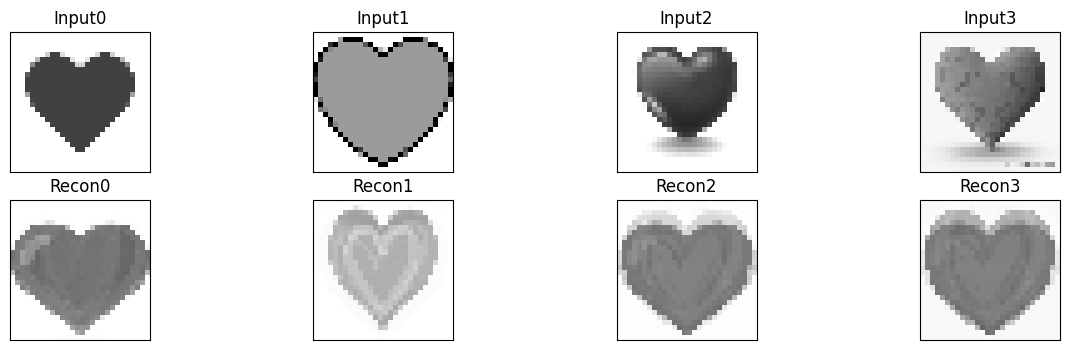

In [ ]:
recon_x_test = model.predict(x_test)

n = min(10, len(x_test))  # how many digits we will display (up to the size of x_test)
plt.figure(figsize=(15, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")  # Adjust the size to (28, 28)
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")  # Adjust the size to (28, 28)
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
